Prototipo Projeto CAR

Loading car from dados/PARA/CAR/AREA_IMOVEL_1.shp...
Loading municipios from dados/PARA/Municipios/PA_Municipios_2023.shp...
Loading uf from dados/PARA/UF/PA_UF_2023.shp...
Loading ucs from dados/PARA/UCs/cat60_protected_area_WGS84_v2.shp...


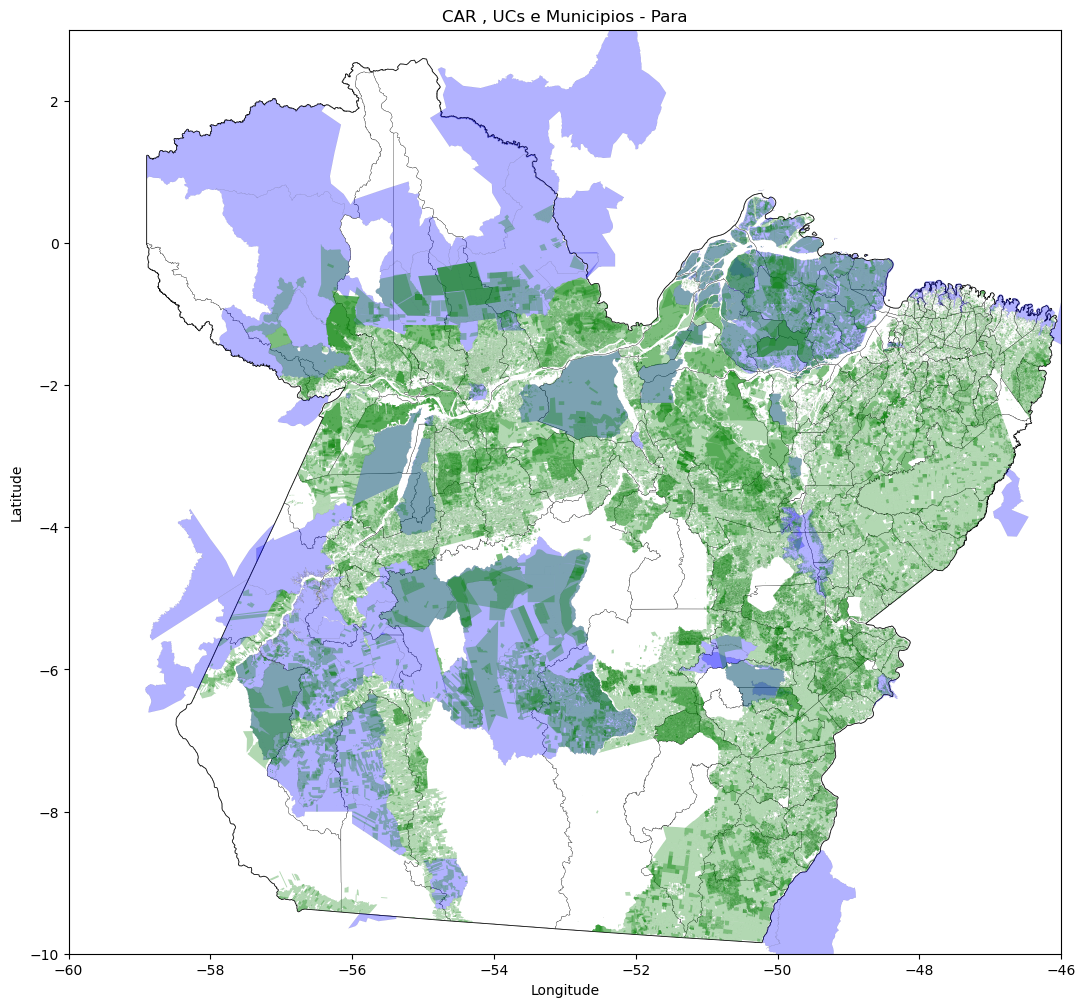

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
from load_data import GeoDataLoader

# Carregar o arquivo shapefile

files = {
        "car": "dados/PARA/CAR/AREA_IMOVEL_1.shp",
        "municipios": "dados/PARA/Municipios/PA_Municipios_2023.shp",
        "uf": "dados/PARA/UF/PA_UF_2023.shp",
        "ucs": "dados/PARA/UCs/cat60_protected_area_WGS84_v2.shp"
        
}

datasets = GeoDataLoader().load_all(files)

gdf,g_m,uf,ucs=datasets["car"],datasets["municipios"],datasets["uf"],datasets["ucs"]



# Garantir que o CRS (Sistema de Referência de Coordenadas) esteja definido e consistente
if gdf.crs is None:  # Verifica se o CRS não está definido
    gdf.set_crs("WGS84", inplace=True)  # Define como WGS84, se necessário

# Plotar os dados limpos
# Configura o tamanho do gráfico
ax=uf.plot(color='white', edgecolor='black',linewidth=1, alpha=1,figsize=(25, 12))
g_m.plot(ax=ax,color='white', edgecolor='black',linewidth=0.2, alpha=1,figsize=(30, 16))
ucs.plot(ax=ax,color='blue', edgecolor='black',linewidth=0.1, alpha=0.3,figsize=(30, 16))
gdf.plot(ax=ax,color='green', edgecolor='black',linewidth=0.01, alpha=0.3,figsize=(30, 16))

# Plota os polígonos em verde com bordas pretas
plt.title("CAR , UCs e Municipios - Para")  # Título do gráfico
plt.xlabel("Longitude")  # Rótulo do eixo X
plt.ylabel("Latitude")  # Rótulo do eixo Y
plt.xlim(-60,-46)
plt.ylim(-10,3)
plt.show()  # Exibe o gráfico

Propiedades que se intercedem:

/tmp/ipykernel_123411/4036956393.py:64: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc="upper right", fontsize=10)
/tmp/ipykernel_123411/4036956393.py:64: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right", fontsize=10)


<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

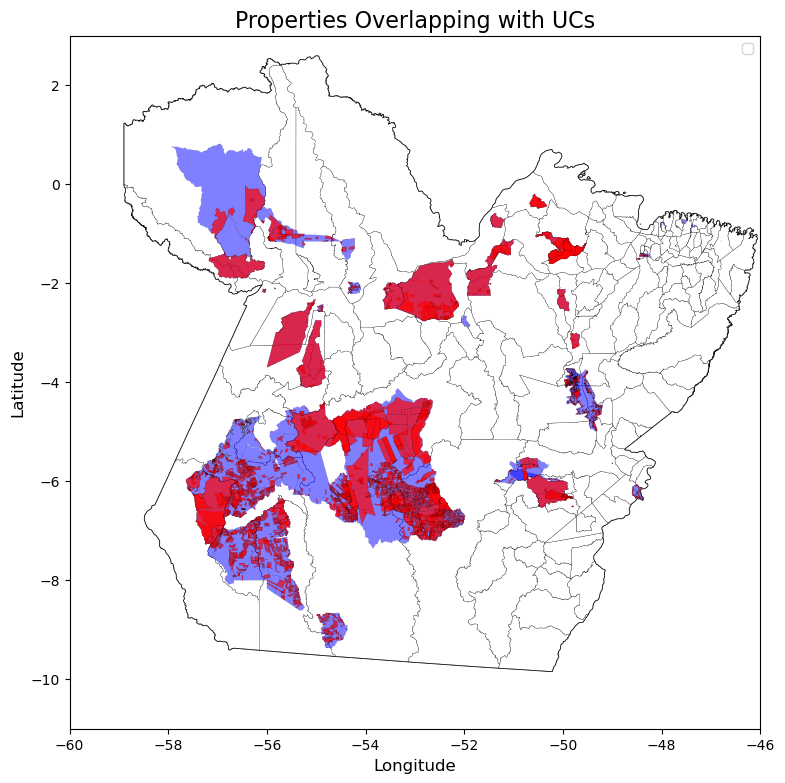

In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt



# Create spatial indexes for faster intersection lookup
gdf_sindex = gdf.sindex
ucs_sindex = ucs.sindex

# Minimum area threshold for intersections
min_area = 0.0001  # Adjust based on your use case

# List to store intersection results
intersection_data = []

# Iterate over UCs to find overlapping properties
for ucs_idx, ucs_geom in ucs.geometry.items():
    # Find possible matches within the UC's bounding box
    possible_matches = list(gdf_sindex.intersection(ucs_geom.bounds))
    
    for prop_idx in possible_matches:
        prop_geom = gdf.geometry.iloc[prop_idx]
        
        # Check for intersection
        if ucs_geom.intersects(prop_geom):
            intersection = ucs_geom.intersection(prop_geom)
            
            # Verify intersection area exceeds threshold
            if not intersection.is_empty and intersection.area >= min_area:
                intersection_data.append({
                    "property_id": gdf.index[prop_idx],
                    "uc_id": ucs.index[ucs_idx],
                    "intersection_area": intersection.area,
                    "geometry": intersection
                })

# Create a GeoDataFrame for intersections
intersecting_gdf = gpd.GeoDataFrame(intersection_data, geometry="geometry", crs=gdf.crs)

# Plot properties, UCs, and intersection areas
plt.figure(figsize=(12, 8), dpi=100)




# Create a GeoDataFrame for intersections
intersecting_gdf = gpd.GeoDataFrame(intersection_data, geometry="geometry", crs=gdf.crs)
    
# Plot properties, UCs, and intersection areas
plt.figure(figsize=(12, 8), dpi=100)

# Plot UCs

ax=uf.plot(color='white', edgecolor='black',linewidth=1, alpha=1,figsize=(20, 9))
g_m.plot(ax=ax,color='white', edgecolor='black',linewidth=0.2, alpha=1,figsize=(30, 16))
ucs.plot(ax=ax,color='blue', edgecolor='black',linewidth=0.1, alpha=0.5,figsize=(30, 16))
# Plot intersections
intersecting_gdf.plot(ax=ax, color="red", edgecolor="black", alpha=0.7, linewidth=0.1, label="Intersections")

# Add title and labels
plt.title("Properties Overlapping with UCs", fontsize=16)
plt.xlabel("Longitude", fontsize=12)
plt.ylabel("Latitude", fontsize=12)
plt.legend(loc="upper right", fontsize=10)
plt.xlim(-60,-46)
plt.ylim(-11,3)
# Show the plot
plt.show()

/tmp/ipykernel_123411/1243352834.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['area'] = gdf.geometry.area


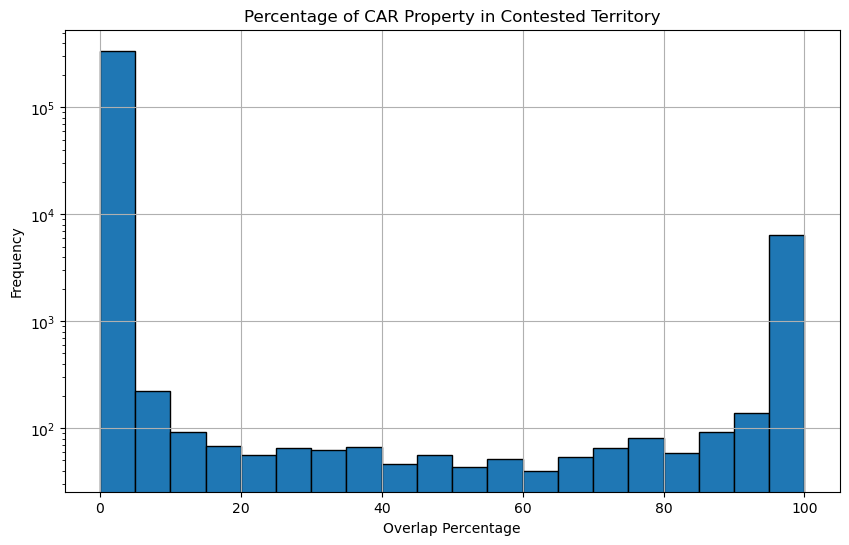

In [4]:
# Calculate the area of each property
gdf['area'] = gdf.geometry.area

# Create a spatial index for the contested regions
spatial_index = intersecting_gdf.sindex

# Initialize a dictionary to store intersection areas for each property
intersection_area_by_id = {}

# Iterate over each property and calculate intersections with contested regions
for idx, row in gdf.iterrows():
    # Query the spatial index to find potential intersections
    potential_intersections_idx = list(spatial_index.intersection(row.geometry.bounds))
    potential_intersections = intersecting_gdf.iloc[potential_intersections_idx]

    # Calculate the total intersection area for the current property
    total_intersection_area = sum(
        row.geometry.intersection(contested_row.geometry).area
        for _, contested_row in potential_intersections.iterrows()
    )

    # Store the total intersection area for the current property
    intersection_area_by_id[idx] = total_intersection_area

# Add the intersection area as a new column to the original GeoDataFrame
gdf['intersection_area'] = gdf.index.map(intersection_area_by_id).fillna(0)

# Calculate the overlap percentage (intersection area / total area)
gdf['overlap_percentage'] = (gdf['intersection_area'] / gdf['area']) * 100

# Ensure overlap percentage is capped at 100%
gdf['overlap_percentage'] = gdf['overlap_percentage'].clip(upper=100)

# Plot the histogram of overlap percentages
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.hist(gdf['overlap_percentage'], bins=20, edgecolor='black')  # Adjust bins as needed
plt.title('Percentage of CAR Property in Contested Territory')
plt.xlabel('Overlap Percentage')
plt.ylabel('Frequency')
plt.yscale("log")
plt.grid(True)
plt.show()

In [17]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the shapefiles
gdf = gpd.read_file("dados/PARA/CAR/AREA_IMOVEL_1.shp")[0:108000]  # Properties
ucs = gpd.read_file("dados/PARA/UCs/cat60_protected_area_WGS84_v2.shp")  # UCs
print(gdf.info())
# Ensure CRS is consistent (assumes both datasets should be in EPSG:4326)
if gdf.crs != ucs.crs:
    ucs = ucs.to_crs(gdf.crs)

# Choose a specific UC by its index or attribute
selected_uc = ucs.iloc[22]  # Replace 0 with the desired UC index
selected_uc_geometry = selected_uc.geometry

# Print selected UC information
print("Selected UC Information:")
print(selected_uc)

# Create a spatial index for properties
gdf_sindex = gdf.sindex

# Minimum area threshold for intersections
min_area = 0.0001  # Adjust based on your use case

# List to store intersection results
intersection_data = []

# Find properties that intersect with the selected UC
possible_matches = list(gdf_sindex.intersection(selected_uc_geometry.bounds))

for prop_idx in possible_matches:
    prop_geom = gdf.geometry.iloc[prop_idx]

    # Check for intersection
    if selected_uc_geometry.intersects(prop_geom):
        intersection = selected_uc_geometry.intersection(prop_geom)

        # Verify intersection area exceeds threshold
        if not intersection.is_empty and intersection.area >= min_area:
            intersection_data.append({
                "property_id": gdf.index[prop_idx],
                "intersection_area": intersection.area,
                "geometry": intersection
            })

# Create a GeoDataFrame for intersections
print(intersection_data)
intersecting_gdf = gpd.GeoDataFrame(intersection_data, geometry="geometry", crs=gdf.crs)


# Plot properties
ax =ucs[ucs.index == selected_uc.name].plot( color="blue", edgecolor="black", alpha=0.7, linewidth=1, label="Selected UC",figsize=(6,8))


intersecting_gdf.plot(ax=ax, color="red", edgecolor="black", alpha=0.7, linewidth=0.5, label="Intersections")

# Plot the selected UC

# Add title and labels
plt.title(f"Properties Overlapping with UC: {selected_uc['id']}", fontsize=12)  # Replace 'NAME' with the actual column name
plt.xlabel("Longitude", fontsize=12)
plt.ylabel("Latitude", fontsize=12)
plt.legend(loc="upper right", fontsize=10)

# Show the plot
plt.show()

# Merge intersecting data with original properties (gdf) to include property info
intersecting_with_info = intersecting_gdf.merge(
    gdf, 
    left_on="property_id", 
    right_index=True, 
    suffixes=("_intersection", "_property")
)

# Print detailed information about overlapping properties
print("Overlapping Properties and Intersection Details:")
print(intersecting_with_info)

# Save the detailed intersecting data to a shapefile if needed
# intersecting_with_info.to_file("selected_uc_overlapping_properties_with_info.shp")


FeatureError: fread(2607) failed on DBF file.

In [ ]:

# Merge intersecting data with original properties (gdf) to include property info
intersecting_with_info = intersecting_gdf.merge(
    gdf, 
    left_on="property_id", 
    right_index=True, 
    suffixes=("_intersection", "_property")
)
# Sort by intersection area in descending order
intersecting_with_info_sorted = intersecting_with_info.sort_values(by="intersection_area", ascending=False)

# Print detailed information about the top 10 overlapping properties
print("Top 10 Overlapping Properties by Intersection Area:")
intersecting_with_info_sorted.head(10)


Top 10 Overlapping Properties by Intersection Area:


,property_id,intersection_area,geometry_intersection,cod_tema,nom_tema,cod_imovel,mod_fiscal,num_area,ind_status,ind_tipo,des_condic,municipio,cod_estado,dat_criaca,dat_atuali,geometry_property
26,58005,0.404982,"POLYGON ((-53.94093 -5.31539, -53.95505 -6.145...",AREA_IMOVEL,Area do Imovel,PA-1500602-C097B0F01F384AEC9D9374A5856166D1,6624.4501,496833.7607,AT,IRU,Aguardando analise,Altamira,PA,24/12/2017,24/12/2017,"POLYGON ((-54.25417 -5.66666, -53.94093 -5.315..."
37,72228,0.061684,"POLYGON ((-53.44439 -5.64343, -53.44441 -5.643...",AREA_IMOVEL,Area do Imovel,PA-1500602-6F16CDC1D84144ED98047F84618E98B1,1063.1551,79736.6342,AT,IRU,Aguardando analise,Altamira,PA,09/08/2019,09/08/2019,"POLYGON ((-53.54143 -5.69823, -53.77186 -5.174..."
34,75795,0.059600,"POLYGON ((-54.02182 -4.73981, -53.90236 -4.739...",AREA_IMOVEL,Area do Imovel,PA-1500602-A9BB42F30D9E4FE29AB4EA7F8D7F583F,979.4786,73460.8937,AT,IRU,Aguardando analise,Altamira,PA,04/12/2019,04/12/2019,"POLYGON ((-53.90236 -4.73931, -53.7786 -4.7390..."
38,77527,0.045478,"MULTIPOLYGON (((-53.87507 -4.62872, -53.73178 ...",AREA_IMOVEL,Area do Imovel,PA-1500602-A2FF61FA996D487991E18FDE683DDBC4,1179.1984,88439.8804,AT,IRU,Aguardando analise,Altamira,PA,04/12/2019,06/02/2020,"POLYGON ((-54.05273 -4.73828, -54.06578 -4.712..."
33,72098,0.043087,"POLYGON ((-53.95491 -5.04435, -53.95308 -5.047...",AREA_IMOVEL,Area do Imovel,PA-1500602-0AE3E26E7C3D447C912C8DC267865FAB,705.6555,52924.1628,AT,IRU,Aguardando analise,Altamira,PA,10/08/2019,10/08/2019,"POLYGON ((-53.95511 -5.04029, -53.95491 -5.044..."
11,31626,0.010497,"POLYGON ((-53.16824 -6.66186, -53.16895 -6.663...",AREA_IMOVEL,Area do Imovel,PA-1507300-9646E26D638B47DCA62EC1996899B70D,171.2585,12844.3855,SU,IRU,"Analisado, aguardando atendimento a notificacao",Sao Felix do Xingu,PA,26/11/2015,26/11/2015,"POLYGON ((-53.20535 -6.7002, -53.20535 -6.6993..."
17,67695,0.007142,"POLYGON ((-53.69749 -6.44894, -53.69737 -6.452...",AREA_IMOVEL,Area do Imovel,PA-1500602-03D75ADA1BB74E139D79019E3E9FD859,228.8298,17162.2342,CA,IRU,Cancelado por decisao administrativa,Altamira,PA,18/12/2018,18/12/2018,"POLYGON ((-53.57583 -6.47, -53.56222 -6.52806,..."
9,83981,0.006130,"POLYGON ((-53.16028 -6.81102, -53.13013 -6.811...",AREA_IMOVEL,Area do Imovel,PA-1507300-D1969C6A61E04F7DBDE70B4BC4F4255D,99.9638,7497.2829,AT,IRU,Aguardando analise,Sao Felix do Xingu,PA,27/11/2015,01/10/2020,"POLYGON ((-53.19003 -6.81089, -53.16028 -6.811..."
41,64582,0.004749,"POLYGON ((-52.80869 -4.32156, -52.79287 -4.321...",AREA_IMOVEL,Area do Imovel,PA-1500602-AE800109D4424334B2596D89E495CC8C,146.5273,10989.5476,CA,IRU,Cancelado por decisao administrativa,Altamira,PA,28/08/2018,28/08/2018,"POLYGON ((-52.80294 -4.29722, -52.73928 -4.315..."
4,43669,0.004341,"POLYGON ((-52.88196 -6.9122, -52.88736 -6.9256...",AREA_IMOVEL,Area do Imovel,PA-1507300-EF9C3A897B5F424FBF9612624B229555,122.2190,9166.4242,CA,IRU,Cancelado por decisao administrativa,Sao Felix do Xingu,PA,05/05/2016,04/08/2016,"POLYGON ((-52.84546 -6.90849, -52.84478 -6.963..."


In [ ]:
import pandas as pd

# Initialize an empty list to store results
results = []

# Calculate the area of rural properties
gdf['area_rural'] = gdf.geometry.area

# Calculate the overlap area between rural properties and UCs
intersecting_gdf['overlap_area'] = intersecting_gdf.geometry.area

# Loop through each city in the city set
for _, city_row in g_m.iterrows():
    city_name = city_row['NM_MUN']  # Assuming the city name is stored in a column named 'NM_MUN'
    city_geometry = city_row.geometry
    city_area = city_geometry.area  # Total area of the city
    print(city_name)
    # Calculate the area of rural properties within the city
    rural_in_city = gdf[gdf.geometry.within(city_geometry)]
    rural_area_in_city = rural_in_city['area_rural'].sum()

    # Find intersections of rural properties in the city with UCs
    rural_in_city_set = rural_in_city.geometry
    overlaps_in_city = intersecting_gdf[intersecting_gdf.geometry.intersects(city_geometry)]
    overlap_area_in_city = overlaps_in_city['overlap_area'].sum()
    
    if(len(overlaps_in_city)>0 and False):
        plt.figure(figsize=(6,6))
        ax=uf.plot(color='white', edgecolor='black',linewidth=1, alpha=1,figsize=(25, 12))
        g_m.plot(ax=ax,color='white', edgecolor='black',linewidth=0.2, alpha=1,figsize=(30, 16))
        overlaps_in_city.plot(ax=ax,color="orange",alpha=0.5)

        plt.show()
    # Calculate percentages
    percent_city_rural = (rural_area_in_city / city_area) * 100 if city_area > 0 else 0
    percent_rural_overlap = (overlap_area_in_city / rural_area_in_city) * 100 if rural_area_in_city > 0 else 0

    # Append results
    results.append({
        "Cidade": city_name,
        "Area": city_area,
        "Area  Rural": rural_area_in_city,
        "pc Rural": percent_city_rural,
        "Overlap Area": overlap_area_in_city,
        "pc Overlap  Rural": percent_rural_overlap
    })

# Convert results to a DataFrame
results_df = pd.DataFrame(results).sort_values("pc Overlap  Rural",ascending=False)

# Display the results
print(results_df)

# Optionally, save to a CSV
results_df.to_csv("city_rural_overlap_analysis.csv", index=False)



/tmp/ipykernel_123733/2991682706.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['area_rural'] = gdf.geometry.area
/tmp/ipykernel_123733/2991682706.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  intersecting_gdf['overlap_area'] = intersecting_gdf.geometry.area


Abaetetuba
Abel Figueiredo
Acará
Afuá
Água Azul do Norte
Alenquer
Almeirim
Altamira
Anajás
Ananindeua
Anapu
Augusto Corrêa
Aurora do Pará
Aveiro
Bagre
Baião
Bannach
Barcarena
Belém
Belterra
Benevides
Bom Jesus do Tocantins
Bonito
Bragança
Brasil Novo
Brejo Grande do Araguaia
Breu Branco
Breves
Bujaru
Cachoeira do Piriá
Cachoeira do Arari
Cametá
Canaã dos Carajás
Capanema
Capitão Poço
Castanhal
Chaves
Colares
Conceição do Araguaia
Concórdia do Pará
Cumaru do Norte
Curionópolis
Curralinho
Curuá
Curuçá
Dom Eliseu
Eldorado do Carajás
Faro
Floresta do Araguaia
Garrafão do Norte
Goianésia do Pará
Gurupá
Igarapé-Açu
Igarapé-Miri
Inhangapi
Ipixuna do Pará
Irituia
Itaituba
Itupiranga
Jacareacanga
Jacundá
Juruti
Limoeiro do Ajuru
Mãe do Rio
Magalhães Barata
Marabá
Maracanã
Marapanim
Marituba
Medicilândia
Melgaço
Mocajuba
Moju
Mojuí dos Campos
Monte Alegre
Muaná
Nova Esperança do Piriá
Nova Ipixuna
Nova Timboteua
Novo Progresso
Novo Repartimento
Óbidos
Oeiras do Pará
Oriximiná
Ourém
Ourilândia do